<a href="https://www.kaggle.com/code/muhammadmeftahmafazy/extraction-audio?scriptVersionId=130779953" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
# feature extractoring and preprocessing data
import librosa
import librosa, librosa.display, os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

#Pytorch
import torch

from imblearn.pipeline import Pipeline

import joblib

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#Other
from IPython.display import Audio
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!ls ../input/coughvid-19/dataset/archive_wav/archive_wav

00039425-7f3a-42aa-ac13-834aaa2b6b92.wav
0009eb28-d8be-4dc1-92bb-907e53bc5c7a.wav
001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f.wav
0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952.wav
00291cce-36a0-4a29-9e2d-c1d96ca17242.wav
002d28bc-7806-4dfb-9c9b-afa8cb623cac.wav
0037f67c-0d6f-42e6-ab94-66499d4d2bf4.wav
003e1bf6-2ecf-4a00-9198-29db34e8d7ac.wav
0044964d-f7e9-43e3-831f-ae3e6374a9a4.wav
0044cb7b-448c-44e5-8302-ad8bd106fe3e.wav
004c24d8-e8cd-4755-86f6-5a1d8c7920c7.wav
005887c9-4bb1-4f13-86b2-1c7b3cee0881.wav
005b8518-03ba-4bf5-86d2-005541442357.wav
005bca13-18d1-4514-a086-cc8c3fafeeb2.wav
00745765-96ed-4e13-8ca7-7f6b793af78d.wav
00753bb4-cffb-472b-b391-09337558a678.wav
007be9cd-6c5d-467f-a89c-e670fae075b4.wav
00802ac6-0e3b-4bba-bcdc-014f1fde7432.wav
008ba489-31ad-44d8-856b-fcf72369dc46.wav
009aa393-32ab-423f-8e6a-63d8d4d1476b.wav
009b1e22-f451-40ae-9cbf-9f1ff5dec022.wav
00a31212-7c64-4649-b78b-4c7d9ce3156e.wav
00bf9f83-2e8f-47cf-a4f2-97f2beceebc1.wav
00c24aac-b6c8-4065-a999-079cb48fcf86.wav
00c2b443-4746-43

In [3]:
dataset = "../input/coughvid-19/dataset/metadata_wav.csv"
train_csv = pd.read_csv(dataset, index_col=0)
train_csv

,file,status
1,00039425-7f3a-42aa-ac13-834aaa2b6b92.wav,healthy
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a.wav,healthy
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f.wav,healthy
10,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952.wav,healthy
11,00291cce-36a0-4a29-9e2d-c1d96ca17242.wav,healthy
...,...,...
27292,fd849b72-f4bf-4852-9bc2-fd9becc9571e.wav,COVID-19
27300,fd8d6e46-75de-42b3-a7ef-30d5294b915d.wav,COVID-19
27315,fdbabb79-c296-4b93-9e02-06b290916fe7.wav,COVID-19
27503,ff8363d2-016d-4738-9499-4c62480886fb.wav,COVID-19


# Converting Audio into Spectrogram

total_rows 1926 columns:  2
0037f67c-0d6f-42e6-ab94-66499d4d2bf4


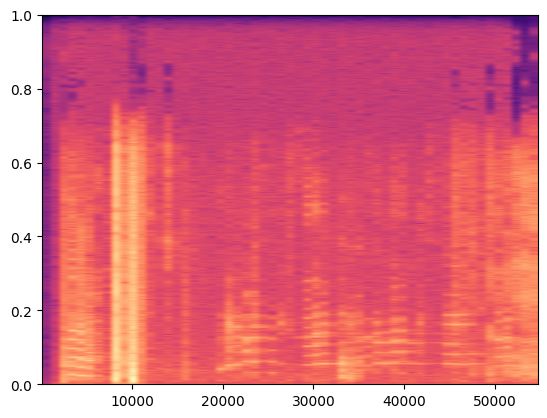

In [4]:
cmap = plt.get_cmap('inferno')
tot_rows = train_csv.shape[0]
print ('total_rows',tot_rows, 'columns: ', train_csv.shape[1])
for i in range(0,1): #Thay range(1) = range(tot_rows)
    source = train_csv.iloc[6]["file"]
    filename = '../input/coughvid-19/dataset/archive_wav/archive_wav/'+source
    y,sr = librosa.load(filename, mono=True, duration=5)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap='magma', sides='default', mode='default', scale='dB');
    #plt.axis('off');
    plt.savefig(f'./{source[:-3].replace(".", "")}.png')
    print (source[:-4]) #Remove the last 4 characters ".wav"
    #plt.clf() 

# Extraction Feature

## For this condition only 6 extraction feature, maybe will changed for the future

*     Chroma Short Time Fourier Transform (STFT)
*     Spectral Centroid
*     Spectral Bandwidth
*     Spectral Rolloff
*     Zero Crossing Rate
*     Mel Frequency Cepstral Coefficient (MFCC)

In [5]:
# Making Header
header = 'filename chroma_stft chroma_cqt chroma_cens chroma_vqt mel_spec rmse spectral_centroid spectral_bandwidth spectral_contrast spectral_flatness rolloff poly_features tonnetz zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
print(header)

['filename', 'chroma_stft', 'chroma_cqt', 'chroma_cens', 'chroma_vqt', 'mel_spec', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast', 'spectral_flatness', 'rolloff', 'poly_features', 'tonnetz', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


In [6]:
# #Proses Ekstraksi Fitur
# file = open('data_new_extended.csv', 'w')
# intervals = [1.0, 1.25, 1.5, 1.75]

# with file:
#     writer = csv.writer(file)
#     writer.writerow(header)

# intervals = [1.0, 1.25, 1.5, 1.75]

# for i in tqdm(range(train_csv.shape[0])):
#     source = train_csv.iloc[i]["file"]
#     file_name = '../input/coughvid-19/dataset/archive_wav/archive_wav/' + source
#     label = train_csv.iloc[i]["status"]
#     y, sr = librosa.load(file_name, mono=True, duration=5)
    
#     chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
#     chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
#     chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
#     chroma_vqt = librosa.feature.chroma_vqt(y=y, sr=sr, intervals=intervals)
#     mel_spectro = librosa.feature.melspectrogram(y=y, sr=sr)
#     rmse = librosa.feature.rms(y=y)
#     spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=1024)
#     spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=1024)
#     spec_cons = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=1024)
#     spec_flat = librosa.feature.spectral_flatness(y=y, hop_length=1024)
#     rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=1024)
#     poly_f = librosa.feature.poly_features(y=y, sr=sr)
#     ton = librosa.feature.tonnetz(y=y, sr=sr)
#     zcr = librosa.feature.zero_crossing_rate(y)
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
#     # Extract LPC coefficients
#     lpc_coefs = librosa.lpc(y=y, order=10)
    
#     # Append feature values and label to the list
#     to_append = f'{np.mean(chroma_stft)} {np.mean(chroma_cqt)} {np.mean(chroma_cens)} {np.mean(chroma_vqt)} {np.mean(mel_spectro)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(spec_cons)} {np.mean(spec_flat)} {np.mean(rolloff)} {np.mean(poly_f)} {np.mean(ton)} {np.mean(zcr)}'
    
#     for e in mfcc:
#         to_append += f' {np.mean(e)}'
    
#     to_append += ' ' + ' '.join(map(str, lpc_coefs))
#     to_append += f' {label}'
    
#     # Write the row to the CSV file
#     with open('data_new_extended.csv', 'a') as file:
#         writer = csv.writer(file)
#         writer.writerow(to_append.split())

In [ ]:
#Proses Ekstraksi Fitur
file = open('data_new_extended.csv', 'w')
intervals = [1.0, 1.25, 1.5, 1.75]

with file:
    writer = csv.writer(file)
    writer.writerow(header)

for i in tqdm(range(train_csv.shape[0])):
        source = train_csv.iloc[i]["file"]
        file_name = '../input/coughvid-19/dataset/archive_wav/archive_wav/'+source
        label =  train_csv.iloc[i]["status"]
        y,sr = librosa.load(file_name, mono=True, duration=5)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
        chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
        chroma_vqt = librosa.feature.chroma_vqt(y=y, sr=sr, intervals=intervals)
        mel_spectro = librosa.feature.melspectrogram(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr,hop_length=1024)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr,hop_length=1024)
        spec_cons = librosa.feature.spectral_contrast(y=y, sr=sr,hop_length=1024)
        spec_flat = librosa.feature.spectral_flatness(y=y, hop_length=1024)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr,hop_length=1024)
        poly_f = librosa.feature.poly_features(y=y, sr=sr)
        ton = librosa.feature.tonnetz(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        
# mendapatkan nilai rata rata, perlu dimasukkan ke var to_append
        to_append = f'{np.mean(chroma_stft)} {np.mean(chroma_cqt)} {np.mean(chroma_cens)} {np.mean(chroma_vqt)} {np.mean(mel_spectro)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(spec_cons)} {np.mean(spec_flat)} {np.mean(rolloff)} {np.mean(poly_f)} {np.mean(ton)} {np.mean(zcr)}'    
        
        #np.mean nilai rata-rata
        librosa.display.specshow(mfcc, x_axis='time') #Show MFCC
        plt.title('MFCC')
        
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {label}'
        value = [str(source)]
        value.extend(to_append.split())
        file = open('./data_new_extended.csv', 'a')
        with file:
            writer = csv.writer(file)
            writer.writerow(value)

# Filling data into .csv

In [ ]:
# Downloading the received file
from IPython.display import HTML
import pandas as pd
import numpy as np

def create_download_link(title = "Download CSV file", filename = "./data_new_extended.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='./data_new_extended.csv')